## Import Libraries


In [69]:
import torch
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import spacy
import torch.optim as optim
import warnings
import re

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data


In [2]:
# BASE_DIRECTORY = "dataset"
BASE_DIRECTORY = "/kaggle/input/flickr8k"

df = pd.read_csv(BASE_DIRECTORY + "/captions.txt")
df["path"] = df["image"].apply(lambda x: BASE_DIRECTORY + "/Images/" + x)
df = df.rename(columns={"image": "id"})
df["id"] = df["id"].str.replace(".jpg", "")
df.head()

,id,caption,path
0,1000268201_693b08cb0e,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...


In [3]:
print("Dataframe shape:", df.shape)
unique_id_count = df["id"].nunique()
print("Number of samples", unique_id_count)

Dataframe shape: (40455, 3)
Number of samples 8091


### Build Dictionary


In [4]:
data = {}

for i in range(0, len(df), 5):
    id = df["id"][i]
    captions = [df["caption"][j] for j in range(i, i + 5)]
    path = df["path"][i]
    data[id] = {"captions": captions, "path": path}

keys = list(data.keys())

key = keys[0]
value = data[key]

print(f"Key: {key}")
value

Key: 1000268201_693b08cb0e


{'captions': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 'path': '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'}

### Split the dictionary into train, test, and validation sets


In [5]:
def read_ids_from_file(filename):
    with open(filename, "r") as f:
        ids = [line.strip() for line in f]
    return ids


BASE_DIRECTORY = "/kaggle/input/id-files"

train_keys = read_ids_from_file(BASE_DIRECTORY + "/train_id.txt")
val_keys = read_ids_from_file(BASE_DIRECTORY + "/val_id.txt")
test_keys = read_ids_from_file(BASE_DIRECTORY + "/test_id.txt")

# Create the training, validation, and testing sets
train_data = {key: data[key] for key in train_keys}
val_data = {key: data[key] for key in val_keys}
test_data = {key: data[key] for key in test_keys}

train_keys = list(train_data.keys())
val_keys = list(val_data.keys())
test_keys = list(test_data.keys())

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Testing set size:", len(test_data))

Training set size: 6000
Validation set size: 1000
Testing set size: 1000


## Read & Show Image Data


In [6]:
def read_image(path):
    return Image.open(path)


def show_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def read_from_tensor(tensor):
    img_numpy = tensor.permute(1, 2, 0).numpy()
    img_numpy = np.clip(img_numpy, 0, 1)
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.show()

### Example of an image with captions


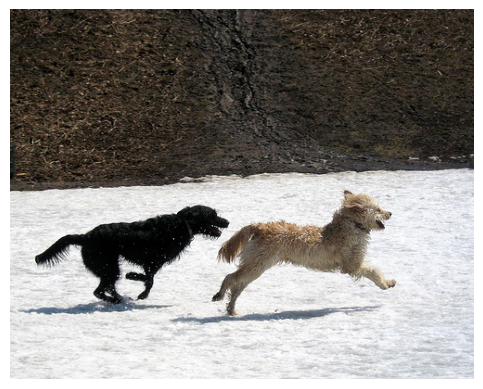

A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .


In [7]:
index = 0
show_image(read_image(train_data[train_keys[index]]["path"]))
for i in range(5):
    print(train_data[train_keys[index]]["captions"][i])

## Image Preprocessing


### Transformations


In [8]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            224, scale=(0.9, 1.0), ratio=(0.95, 1.05), antialias=True
        ),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

### Data to Tensor Conversion


In [9]:
train_tensors = [
    train_transform(read_image(train_data[key]["path"])) for key in train_keys
]
train_tensors = torch.stack(train_tensors)

val_tensors = [
    val_test_transform(read_image(val_data[key]["path"])) for key in val_keys
]
val_tensors = torch.stack(val_tensors)

test_tensors = [
    val_test_transform(read_image(test_data[key]["path"])) for key in test_keys
]
test_tensors = torch.stack(test_tensors)


print("Training tensor shape:", train_tensors.shape)
print("Validation tensor shape:", val_tensors.shape)
print("Testing tensor shape:", test_tensors.shape)

Training tensor shape: torch.Size([6000, 3, 224, 224])
Validation tensor shape: torch.Size([1000, 3, 224, 224])
Testing tensor shape: torch.Size([1000, 3, 224, 224])


### Map the captions to the image from tensors


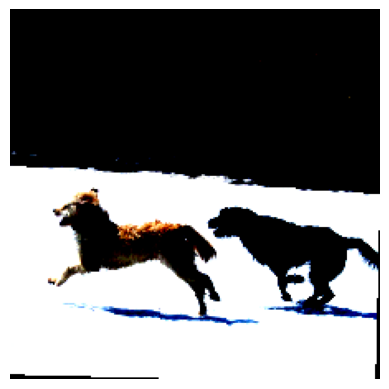

A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .


In [10]:
read_from_tensor(train_tensors[index])
for i in range(5):
    print(train_data[train_keys[index]]["captions"][i])

## Dataset & DataLoader


## Dataset


In [11]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, keys, tensors):
        self.data = data
        self.keys = keys
        self.tensors = tensors

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        key = self.keys[index]
        tensor = self.tensors[index]
        captions = self.data[key]["captions"]
        return tensor, captions

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

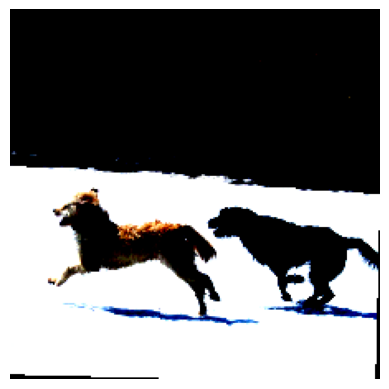

A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .


In [12]:
train_dataset = ImageCaptionDataset(train_data, train_keys, train_tensors)
val_dataset = ImageCaptionDataset(val_data, val_keys, val_tensors)
test_dataset = ImageCaptionDataset(test_data, test_keys, test_tensors)

X, y = train_dataset[index]
print(X)
read_from_tensor(X)
for i in range(5):
    print(y[i])

## DataLoader


In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## ResNet


In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[
            :-2
        ]  # Remove the last two layers (fc and avgpool)
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(
            resnet.fc.in_features, embed_size
        )  # Resnet fc.in_features is 2048
        self.ln = nn.LayerNorm(embed_size)  # Use LayerNorm instead of BatchNorm1d
        self.embed_size = embed_size

    def forward(self, images):
        features = self.resnet(images)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 2048)
        features = self.fc(features)  # Reduce to (batch_size, embed_size)
        features = self.ln(features)
        features = features.view(
            features.size(0), 1, 1, self.embed_size
        )  # Reshape to (batch_size, 1, 1, embed_size)
        return features


# Instantiate the model and move it to the appropriate device
encoder = EncoderCNN(512).to(device)

# Test the encoder with a single image
test_image = train_tensors[index].unsqueeze(0).to(device)
print(test_image.shape)

feature = encoder(test_image)
print(feature.shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 1, 512])


## RNN Preprocessing


In [15]:
nlp = spacy.load("en_core_web_sm")


class Vocab:
    def __init__(self):
        self.vocab_map = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.index_map = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.max_length = 0
        self.sequences = []


    def build_sequences(self):
        for data in train_dataset:
            _, y = data
            for sequence in y:
                self.sequences.append(sequence)
                self.max_length = max(self.max_length, len(self.tokenize(sequence))) # here modified      

    def build_vocab(self):
        self.build_sequences()
        index = 4
        for sequence in self.sequences:
            for word in self.tokenize(sequence):
                if word not in self.vocab_map:
                    self.index_map[index] = word
                    self.vocab_map[word] = index
                    index += 1

    def clean(self,sequence):  
            # preprocessing steps
            # convert to lowercase
            sequence = sequence.lower()
            # delete digits, special chars, etc., 
            sequence = re.sub('[^A-Za-z]', '', sequence)
            # add start and end tags to the caption
            sequence = 'SOS ' +sequence+ ' EOS'
            return sequence
                        

    def tokenize(self, sequence):
        tokenized_sequence = []
        tokenized_sequence.append("SOS")
        for token in nlp.tokenizer(sequence):
           if token.text!= '.':
            tokenized_sequence .append(token.text.lower())
          

        return tokenized_sequence

    def add_padd(self, sequence):

        sequence = sequence +" PAD" * ( self.max_length - len(sequence.split(" ")))
        return sequence

    def __len__(self):
        return len(self.vocab_map)

    def vectorize(self, sequence):
        tokenized_sequence = self.tokenize(sequence)
        for i in range(len(tokenized_sequence), self.max_length):
            tokenized_sequence.append("PAD")
        vectorized_sequence = [
            (
                self.vocab_map[token]
                if token in self.vocab_map
                else self.vocab_map["UNK"]
            )
            for token in tokenized_sequence
        ]
        return vectorized_sequence

In [16]:
vocab = Vocab()
vocab.build_vocab()

vocab_map = vocab.vocab_map
vocab_size = len(vocab_map)
print("Vocab size:", vocab_size)

Vocab size: 7388


## RNN


### Attention Mechanism


In [17]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.tanh(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

### RNN Decoder


In [49]:
class RNNModule(nn.Module):
    def __init__(
        self,
        embed_size,
        hidden_size,
        input_size,
        vocab_size,
        attention_dim,
        num_layers=1,
    ):
        super(RNNModule, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.attention = Attention(
            encoder_dim=input_size, decoder_dim=hidden_size, attention_dim=attention_dim
        )
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.init_h = nn.Linear(input_size, hidden_size)
        self.init_c = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(
            embed_size + input_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.fc.weight)
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        self.fc.bias.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        hidden, cell = self.init_hidden(features)
        outputs = torch.zeros(captions.size(0), captions.size(1), self.vocab_size).to(
            features.device
        )
        for t in range(captions.size(1)):
            attention_weighted_encoding, _ = self.attention(features, hidden[-1])
            lstm_input = torch.cat(
                (embeddings[:, t], attention_weighted_encoding), dim=1
            ).unsqueeze(1)
            lstm_output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
            outputs[:, t] = self.fc(lstm_output.squeeze(1))

        return outputs

    def init_hidden(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = self.init_c(mean_features).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h, c

    def generate_caption(self, features, vocab, max_caption_length=20):
        caption = []
        hidden, cell = self.init_hidden(features)
        sos = torch.tensor(vocab.vocab_map["SOS"]).view(1, -1).to(features.device)
        embed = self.embedding(sos)
        for i in range(max_caption_length):
            attention_weighted_encoding, _ = self.attention(features, hidden[-1])
            lstm_input = torch.cat(
                (embed[:, 0], attention_weighted_encoding), dim=1
            ).unsqueeze(1)
            lstm_output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
            outputs = self.fc(lstm_output.squeeze(1))
            outputs = outputs.argmax(1)
            caption.append(outputs.item())
            if outputs.item() == vocab.vocab_map["EOS"]:
                break
            embed = self.embedding(outputs.unsqueeze(0))
        return caption

## Encoder Decoder

In [50]:
class EncoderDecoder(nn.Module):
    def __init__(
        self,
        embed_size,
        hidden_size,
        input_size,
        vocab_size,
        attention_dim,
        num_layers=1,
    ):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = RNNModule(
            embed_size, hidden_size, input_size, vocab_size, attention_dim, num_layers
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        features = features.squeeze(0)
        outputs = self.decoder(features, captions)
        return outputs

In [141]:
embed_size = 512
hidden_size = 512
input_size = 512
attention_dim = 256
num_layers = 1
learning_rate = 0.005
num_epochs = 10
print_every = 100

In [142]:
model = EncoderDecoder(
    embed_size, hidden_size, input_size, vocab_size, attention_dim, num_layers
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab_map["PAD"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Save Chechpoint

In [143]:
def save_checkpoint(state, filename='/kaggle/working/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='/kaggle/working/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [ ]:
resume_training = False
if resume_training:
    start_epoch, best_loss = load_checkpoint('/kaggle/working/checkpoint.pth.tar')

for epoch in range(start_epoch, num_epochs):
    # Create a progress bar
    progress_bar = tqdm(enumerate(train_dataloader.dataset), total=len(train_dataloader.dataset), leave=False)

    for i, (images, captions) in progress_bar:
        captions = [vocab.vectorize(caption) for caption in captions]
        captions = torch.tensor(captions).to(device)
        images = images.to(device)
        if len(images.shape) == 3:
            images = images.unsqueeze(0)
        outputs = model(images, captions[0].unsqueeze(0))
        loss = criterion(outputs.view(-1, vocab_size), captions[0].view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_description(f"Epoch: {epoch} Loss: {loss.item():.5f}")

        if (i + 1) % print_every == 0:
            model.eval()
            with torch.no_grad():
                dataiter = iter(train_dataloader.dataset)
                img, _ = next(dataiter)
                features = model.encoder(images)

                caption_ids = model.decoder.generate_caption(
                    features.squeeze(0), vocab=vocab, max_caption_length=20
                )
                caption = " ".join([vocab.index_map[idx] for idx in caption_ids])
            
            model.train()

    # Close the progress bar at the end of the epoch
    progress_bar.close()
    
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, filename='/kaggle/working/checkpoint.pth.tar')

Epoch: 1 Loss: 0.32892:  27%|██▋       | 1600/6000 [02:18<06:34, 11.16it/s] 

In [118]:
def get_caption_from(features_tensors):
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps = model.decoder.generate_caption(features.squeeze(0),vocab = vocab)
        caption = " ".join([vocab.index_map[idx] for idx in caps])
    return caption

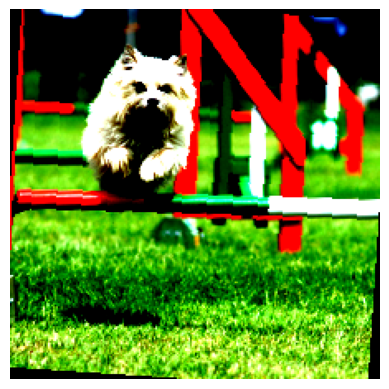

sippy kneel kneel frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning frowning


In [130]:
dataiter = iter(train_dataloader)
images,_ = next(dataiter)

img = images[0]
caps = get_caption_from(img.unsqueeze(0))
read_from_tensor(img)
print(caps)